**Connect to drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Getting dataset from kaggle**

In [ ]:
%run /content/drive/MyDrive/Colab\ Notebooks/kaggle_automation.py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter the Kaggle dataset name (e.g., 'heptapod/titanic'): aakash50897/churn-modellingcsv
Enter the download path (default is current directory): 
Dataset 'aakash50897/churn-modellingcsv' downloaded and unzipped to '.'.


**Importing independeces**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import joblib
import numpy as np

**Data exploration**

In [ ]:
data = pd.read_csv("/content/Churn_Modelling.csv")

In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
print(f"there are {data.shape[0]} rows and {data.shape[1]} columns")

there are 10000 rows and 14 columns


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [ ]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['int64','float64']).columns

print(f"categorical columns are {categorical_columns.tolist()}")
print(f"numerical columns are {numerical_columns.tolist()}")

categorical columns are ['Surname', 'Geography', 'Gender']
numerical columns are ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [ ]:
duplicates = data.duplicated().sum()
print(f"number of duplicated rows are {duplicates}")

number of duplicated rows are 0


In [ ]:
#imbalanced data as one class represents more than 70% of the data
data['Exited'].value_counts(normalize=True)*100

,proportion
Exited,
0,79.63
1,20.37


In [ ]:
# drop unneeded features
data = data.drop(['Surname', 'Geography', 'Gender','RowNumber','CustomerId'], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Age              10000 non-null  int64  
 2   Tenure           10000 non-null  int64  
 3   Balance          10000 non-null  float64
 4   NumOfProducts    10000 non-null  int64  
 5   HasCrCard        10000 non-null  int64  
 6   IsActiveMember   10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   Exited           10000 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 703.3 KB


**Visualization**

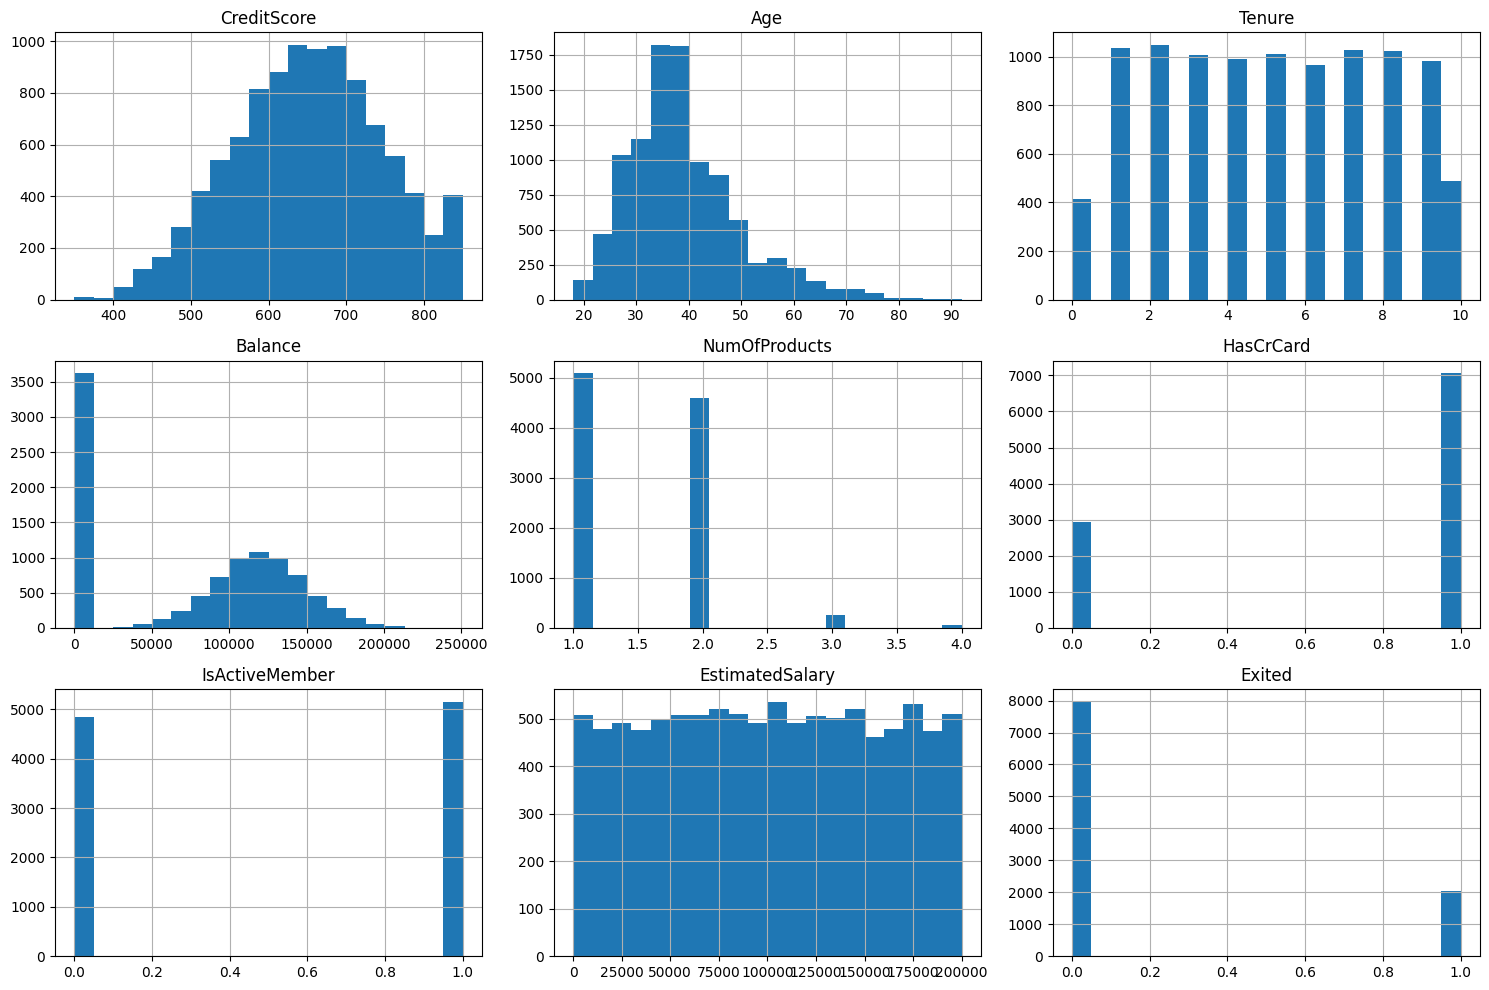

In [ ]:
# show data distribution
data.hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

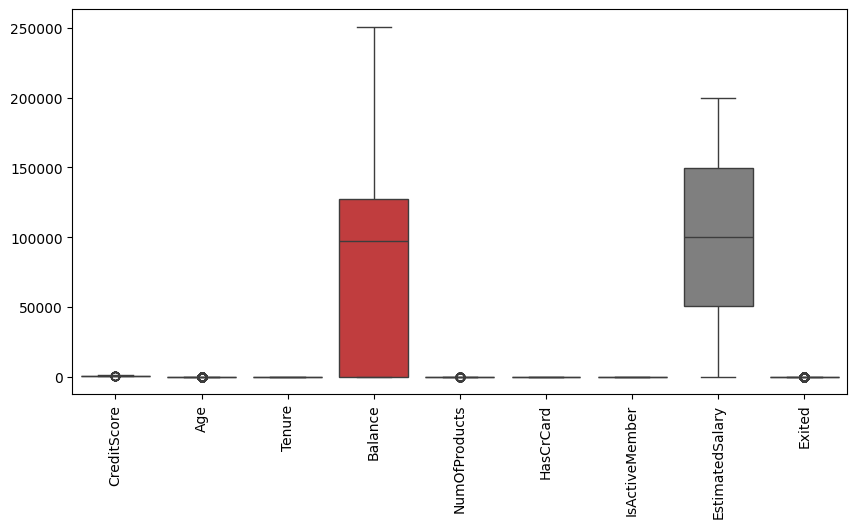

In [ ]:
# check for outlieres
plt.figure(figsize=(10,5))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.show()

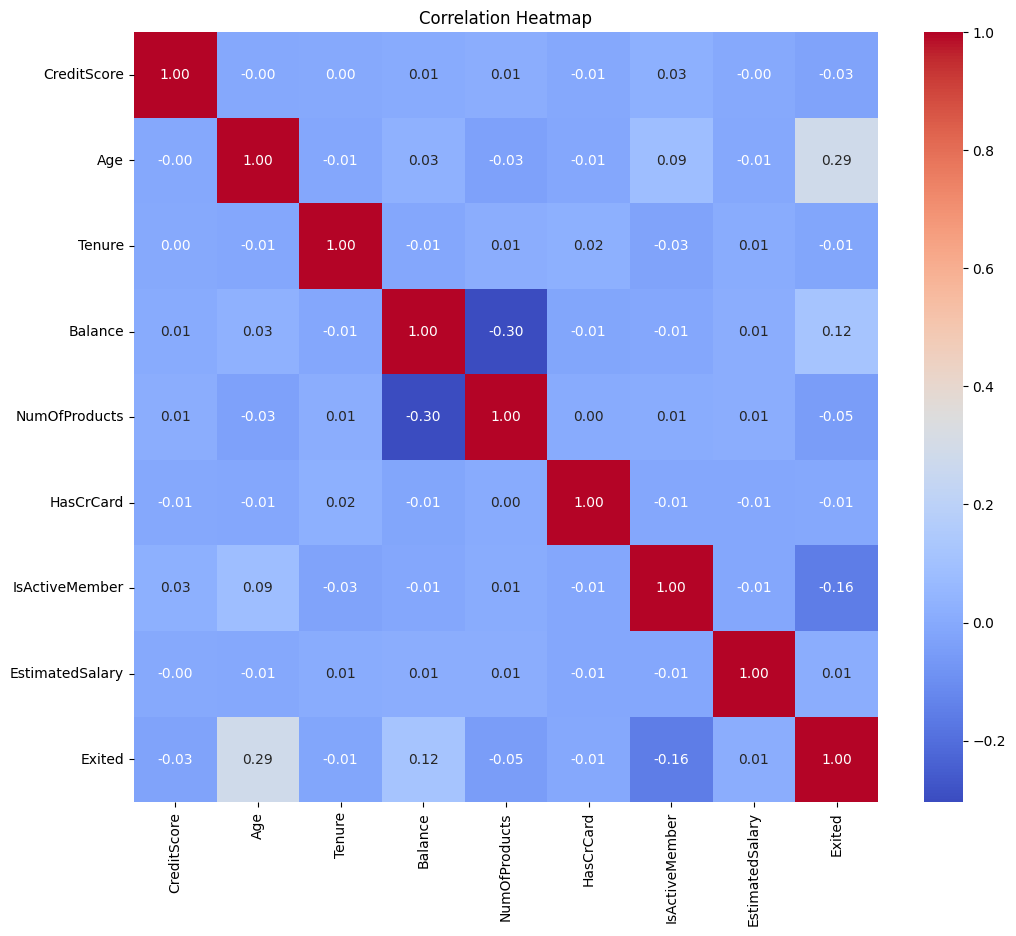

In [ ]:
# see how features affects the target
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Feature engineering**

In [ ]:
#  adding new features to the original data as the original data has a very poor relation with the target
data['Age_Tenure_Interaction'] = data['Age'] * data['Tenure']
data['Active_Balance'] = data['IsActiveMember'] * data['Balance']
data['Active_NumProducts'] = data['IsActiveMember'] * data['NumOfProducts']
data['Balance_Salary_Ratio'] = data['Balance'] / (data['EstimatedSalary'] + 1)
data['Balance_Credit_Ratio'] = data['Balance'] / (data['CreditScore'] + 1)
data['Stability_Score'] = (data['Tenure'] * data['IsActiveMember']) / (data['NumOfProducts'] + 1)
data['Credit_Utilization'] = data['CreditScore'] / (data['Balance'] + 1)
data['Product_Engagement'] = data['NumOfProducts'] * data['IsActiveMember']
data['Age_Balance_Ratio'] = data['Age'] / (data['Balance'] + 1)

In [ ]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_Tenure_Interaction,Active_Balance,Active_NumProducts,Balance_Salary_Ratio,Balance_Credit_Ratio,Stability_Score,Credit_Utilization,Product_Engagement,Age_Balance_Ratio
0,619,42,2,0.00,1,1,1,101348.88,1,84,0.00,1,0.000000,0.000000,1.0,619.000000,1,42.000000
1,608,41,1,83807.86,1,0,1,112542.58,0,41,83807.86,1,0.744670,137.615534,0.5,0.007255,1,0.000489
2,502,42,8,159660.80,3,1,0,113931.57,1,336,0.00,0,1.401362,317.417097,0.0,0.003144,0,0.000263
3,699,39,1,0.00,2,0,0,93826.63,0,39,0.00,0,0.000000,0.000000,0.0,699.000000,0,39.000000
4,850,43,2,125510.82,1,1,1,79084.10,0,86,125510.82,1,1.587035,147.486275,1.0,0.006772,1,0.000343


**Feature selection**

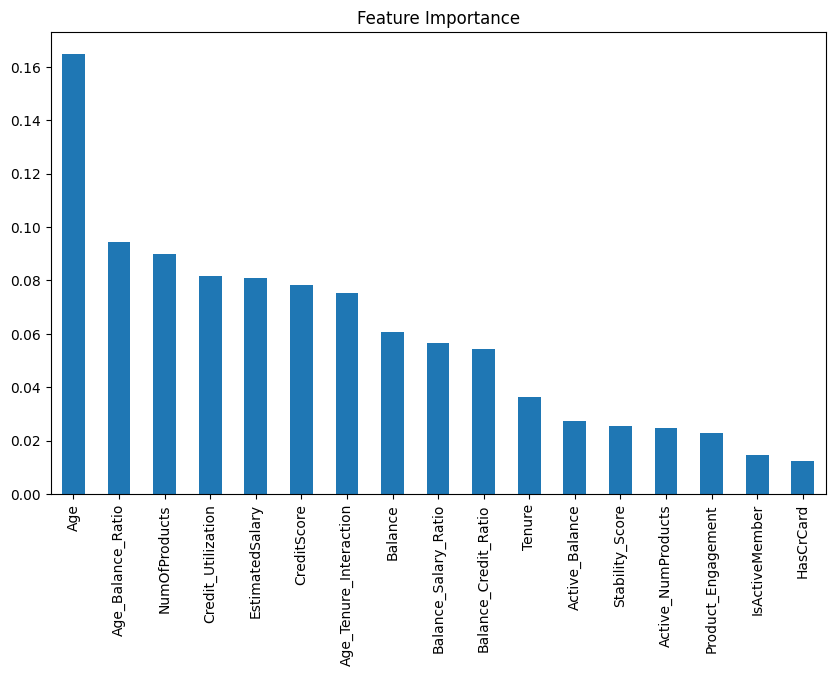

In [ ]:
X = data.drop('Exited', axis=1)
y = data['Exited']

# Train a simple Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Feature importance plot
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importance')
plt.show()


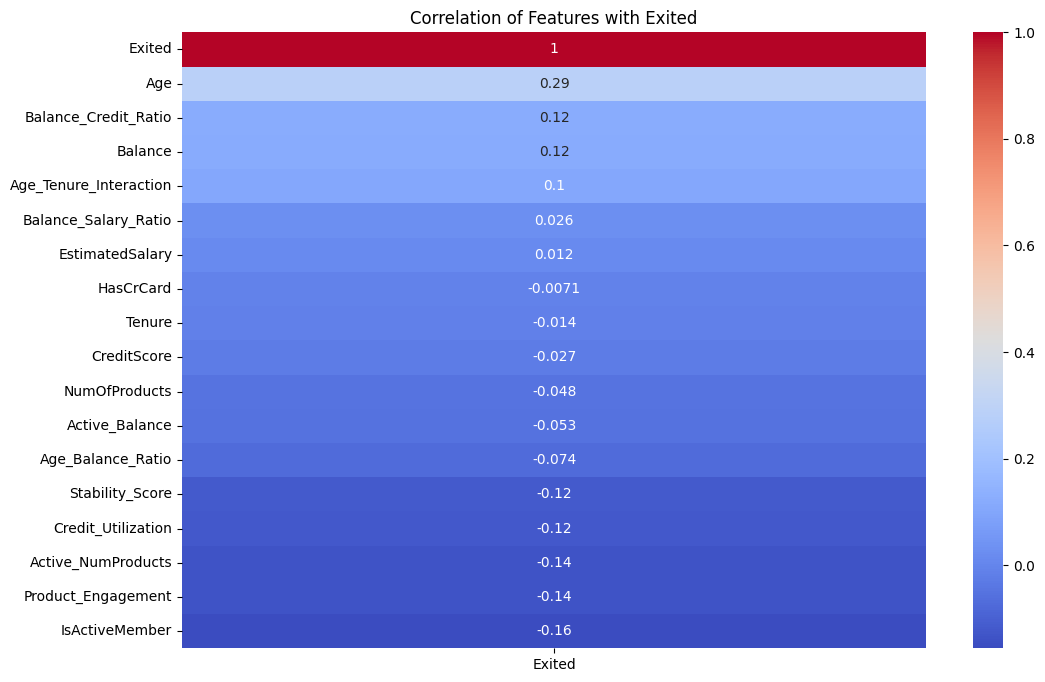

In [ ]:
# view the correlation after adding the new featuers
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr()[['Exited']].sort_values(by='Exited', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Exited')
plt.show()


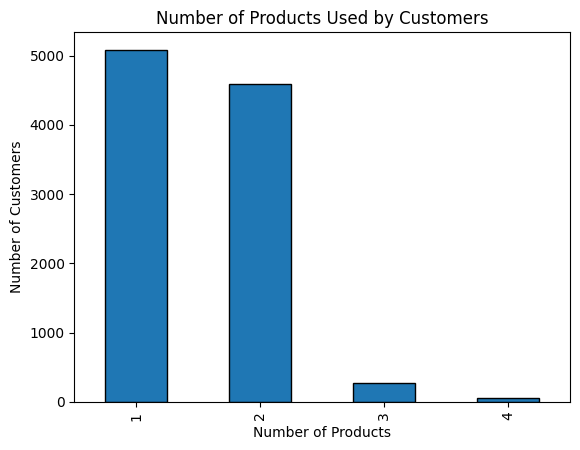

In [ ]:
# showing the frequency of each value in the NumOfProducts features using barplot
data['NumOfProducts'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Number of Products Used by Customers')
plt.xlabel('Number of Products')
plt.ylabel('Number of Customers')
plt.show()

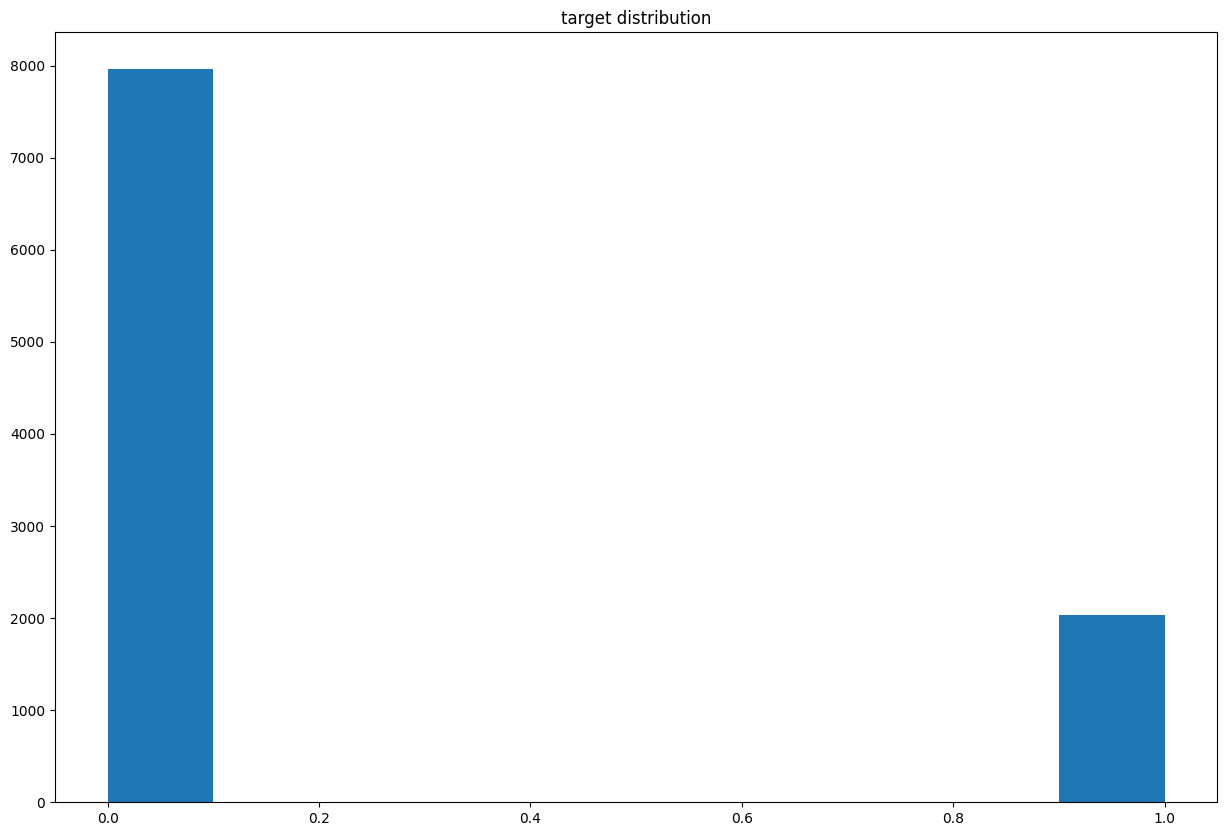

In [ ]:
# distribution of the target
plt.figure(figsize=(15,10))
plt.hist(data['Exited'])
plt.title('target distribution')
plt.show()

# preprocessing before KNN model training

**KNN Assumptions**

1. Feature Scaling Matters (Distance-Based Algorithm):
 KNN is a distance-based algorithm (usually using Euclidean distance).
Features on different scales (e.g., Balance in thousands vs. Age in years) will distort distance calculations.

2. Standardization (Z-score normalization) or Min-Max scaling is critical.

3. Sensitive to Outliers: Outliers can skew the neighborhood.Since there are no outliers, so We're good here.

4. Balanced Classes Improve Performance: Since KNN is sensitive to class imbalance, using SMOTE will help.

In [ ]:
x_knn = data.drop('Exited',axis=1)
y_knn = data['Exited']

x_knn_train,x_knn_test,y_knn_train,y_knn_test = train_test_split(x_knn,y_knn,test_size=0.2,random_state=42,stratify=y_knn)


In [ ]:
x_knn_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age_Tenure_Interaction,Active_Balance,Active_NumProducts,Balance_Salary_Ratio,Balance_Credit_Ratio,Stability_Score,Credit_Utilization,Product_Engagement,Age_Balance_Ratio
5702,585,36,7,0.00,2,1,0,94283.09,252,0.0,0,0.000000,0.000000,0.000000,585.000000,0,36.000000
3667,525,33,4,131023.76,2,0,0,55072.93,132,0.0,0,2.379052,249.094601,0.000000,0.004007,0,0.000252
1617,557,40,4,0.00,2,0,1,105433.53,160,0.0,2,0.000000,0.000000,1.333333,557.000000,2,40.000000
5673,639,34,5,139393.19,2,0,0,33950.08,170,0.0,0,4.105707,217.801859,0.000000,0.004584,0,0.000244
4272,640,34,3,77826.80,1,1,1,168544.85,102,77826.8,1,0.461754,121.414665,1.500000,0.008223,1,0.000437


In [ ]:
x_knn_test.to_csv('/content/x_knn_test.csv', index=False)

In [ ]:
# Check Class Balance Before SMOTE
print(f'Before SMOTE: {Counter(y_knn_train)}')
# Apply SMOTE with Tomek Links to remove noisy synthetic samples
smote_tomek = SMOTETomek(random_state=42)
X_knn_train_resampled, y_knn_train_resampled = smote_tomek.fit_resample(x_knn_train, y_knn_train)

# Check Class Balance After SMOTE
print(f'After SMOTE: {Counter(y_knn_train_resampled)}')


Before SMOTE: Counter({0: 6370, 1: 1630})
After SMOTE: Counter({1: 5580, 0: 5580})


In [ ]:
# Initialize the scaler
robust_scaler = RobustScaler()

# Fit on training data and transform both train and test sets
X_knn_train_scaled = robust_scaler.fit_transform(X_knn_train_resampled)
x_knn_test_scaled = robust_scaler.transform(x_knn_test)

In [ ]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_knn_train_scaled, y_knn_train_resampled)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate with the best model
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(x_knn_test_scaled)

print(classification_report(y_knn_test, y_pred_knn))


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1593
           1       0.42      0.64      0.50       407

    accuracy                           0.74      2000
   macro avg       0.65      0.70      0.67      2000
weighted avg       0.80      0.74      0.76      2000



# Multinomial Naive Bayes

it assumes :
1. Feature Independence
2. Multinomial Distribution (The Multinomial Naive Bayes assumes that features represent discrete counts or frequencies of events.)
3.  Non-Negative Feature Values

In [ ]:
# 1. Select continuous features to bin
features_to_bin = ['Age_Balance_Ratio', 'Age_Tenure_Interaction',
                   'Active_Balance', 'Active_NumProducts',
                   'Balance_Salary_Ratio', 'Balance_Credit_Ratio',
                   'Stability_Score', 'Credit_Utilization',
                   'Product_Engagement', 'CreditScore', 'Age',
                   'Balance', 'EstimatedSalary']

# 2. Initialize the discretizer (uniform bins into 5 categories)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# 3. Apply the discretization
data_binned = discretizer.fit_transform(data[features_to_bin])

# 4. Convert binned data back to a DataFrame
data_binned_df = pd.DataFrame(data_binned, columns=features_to_bin)

# 5. Concatenate binned features with the target variable
data_nb = pd.concat([data_binned_df, data['Exited'].reset_index(drop=True)], axis=1)

In [ ]:
# 6. Split data (stratify to maintain class ratio)
X_nb = data_nb.drop('Exited', axis=1)
y_nb = data_nb['Exited']

X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(
    X_nb, y_nb, test_size=0.2, random_state=42, stratify=y_nb
)

In [ ]:
# 7. Apply SMOTETomek to balance the training set
print(f'Before SMOTE: {Counter(y_nb_train)}')
smote_tomek_nb = SMOTETomek(random_state=42)
X_nb_train_resampled, y_nb_train_resampled = smote_tomek_nb.fit_resample(X_nb_train, y_nb_train)
print(f'After SMOTE: {Counter(y_nb_train_resampled)}')

Before SMOTE: Counter({0: 6370, 1: 1630})
After SMOTE: Counter({1: 6367, 0: 6367})


In [ ]:
# Train Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_nb_train_resampled, y_nb_train_resampled)

# Make predictions
y_pred = nb_model.predict(X_nb_test)

# Evaluate the model
print(classification_report(y_nb_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.64      0.73      1593
           1       0.29      0.59      0.39       407

    accuracy                           0.63      2000
   macro avg       0.58      0.61      0.56      2000
weighted avg       0.74      0.63      0.66      2000



# Gaussian Naive bayes preprocessing

it assumes:
1. Feature Independence
2. Gaussian (Normal) Distribution of Features
3. Continuous Numerical Features

In [ ]:
from sklearn.naive_bayes import GaussianNB
# 1. Define features and target
X_nb_2 = data.drop('Exited', axis=1)
y_nb_2 = data['Exited']

# 2. Split data (stratify to maintain class ratio)
X_nb_train_2, X_nb_test_2, y_nb_train_2, y_nb_test_2 = train_test_split(
    X_nb_2, y_nb_2, test_size=0.2, random_state=42, stratify=y_nb
)


In [ ]:
# 3. Apply SMOTE to balance the training set
print(f'Before SMOTE: {Counter(y_nb_train)}')
smote_tomek_nb = SMOTETomek(random_state=42)
X_nb_train_resampled_2, y_nb_train_resampled_2 = smote_tomek_nb.fit_resample(X_nb_train_2, y_nb_train_2)
print(f'After SMOTE: {Counter(y_nb_train_resampled_2)}')

Before SMOTE: Counter({0: 6370, 1: 1630})
After SMOTE: Counter({1: 5580, 0: 5580})


In [ ]:
standard_scaler = StandardScaler()
X_nb_train_scaled = standard_scaler.fit_transform(X_nb_train_resampled_2)
X_nb_test_scaled = standard_scaler.transform(X_nb_test_2)

In [ ]:
# 5. Train Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_nb_train_scaled, y_nb_train_resampled_2)

# 6. Make predictions
y_pred_nb_2 = gnb.predict(X_nb_test_scaled)

# 7. Evaluate the model
print(classification_report(y_nb_test_2, y_pred_nb_2))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1593
           1       0.40      0.40      0.40       407

    accuracy                           0.75      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.75      0.75      0.75      2000



# Support Vector Machine (SVM) preprocessing

1. Use kernel tricks for non-linear data.
2. Feature Scaling is Essential
3. Sensitive to Outliers so we uses RobustScaler

In [ ]:
X_svm = data.drop('Exited', axis=1)
y_svm = data['Exited']

# Split the data
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42, stratify=y_svm)


In [ ]:
# Initialize the scaler
robust_scaler = RobustScaler()

# Fit on training data and transform both train and test sets
X_svm_train_scaled = robust_scaler.fit_transform(X_svm_train)
X_svm_test_scaled = robust_scaler.transform(X_svm_test)


In [ ]:
# Initialize the SVM model with class balancing
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# Train the model
svm_model.fit(X_svm_train_scaled, y_svm_train)

# Make predictions
y_pred_svm = svm_model.predict(X_svm_test_scaled)

# Evaluate the model
print(classification_report(y_svm_test, y_pred_svm))


              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1593
           1       0.38      0.65      0.48       407

    accuracy                           0.71      2000
   macro avg       0.63      0.69      0.64      2000
weighted avg       0.79      0.71      0.73      2000



# DT preprocessing
1. No Need for Feature Scaling
2. No Assumption of Data Distribution
3. Handles Both Numerical and Categorical Data
4. Insensitive to Outliers
5. Feature Independence is Not Required

In [ ]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:

# Define hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                           param_grid,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_dtree = grid_search.best_estimator_
y_pred_best = best_dtree.predict(X_test)

print(classification_report(y_test, y_pred_best))


Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1593
           1       0.53      0.68      0.59       407

    accuracy                           0.81      2000
   macro avg       0.72      0.76      0.73      2000
weighted avg       0.83      0.81      0.82      2000



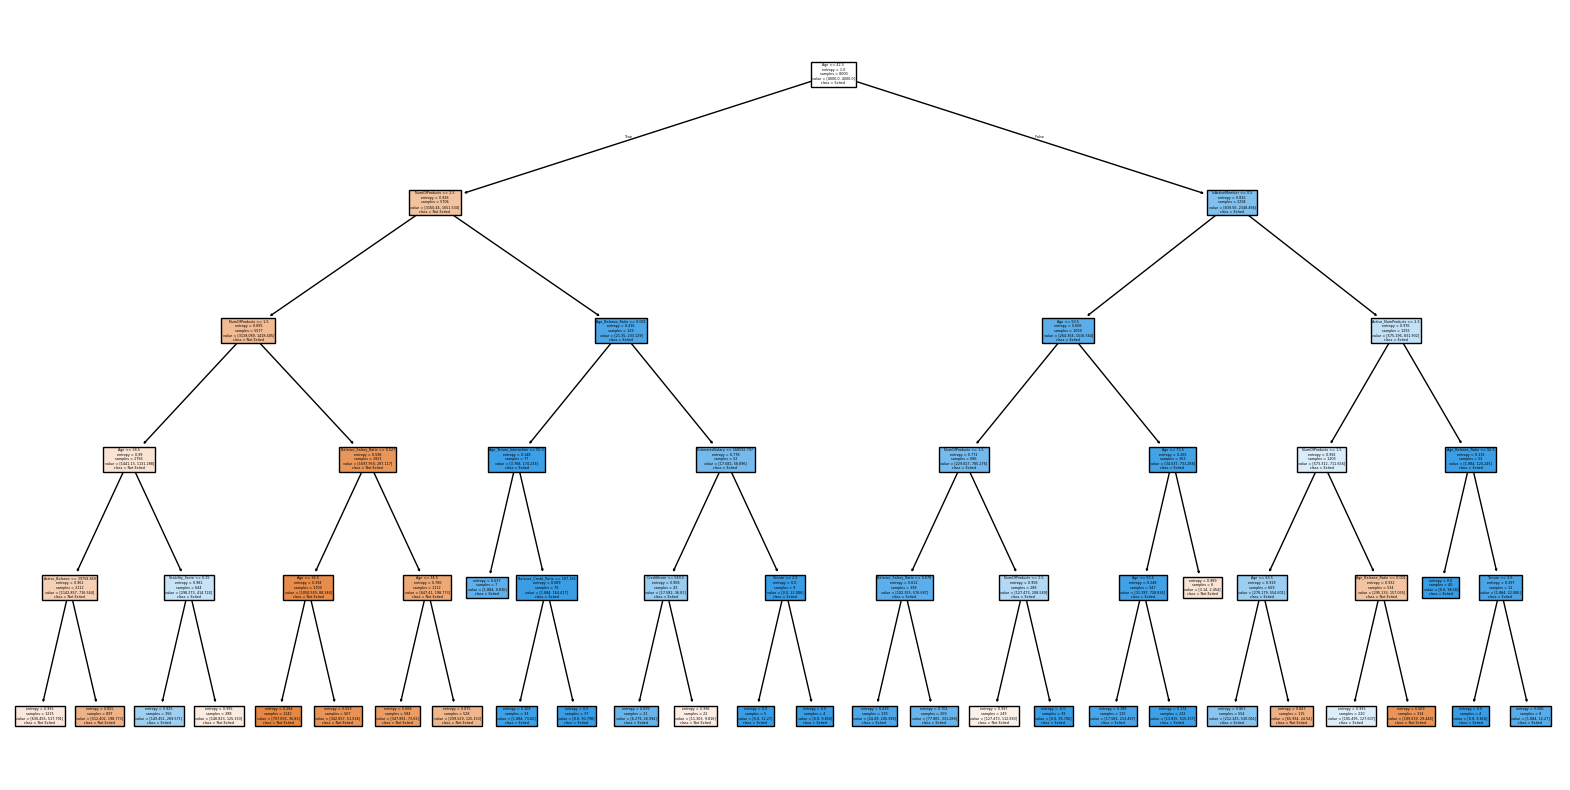

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_dtree, filled=True, feature_names=X.columns, class_names=['Not Exited', 'Exited'])
plt.show()


# **comparison between different algorithms**

In [ ]:
def evaluate_model(y_true, y_pred, y_prob):
    """
    Evaluate the model performance on multiple metrics.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels
    - y_prob: Predicted probabilities (for ROC-AUC)

    Returns:
    - A dictionary containing all metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob[:, 1])  # For binary classification

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

In [ ]:
# Evaluate KNN model
y_pred_knn = best_knn.predict(x_knn_test_scaled)
y_prob_knn = best_knn.predict_proba(x_knn_test_scaled)

knn_metrics = evaluate_model(y_knn_test, y_pred_knn, y_prob_knn)

In [ ]:
# Evaluate Gaussian Naive Bayes model
y_pred_nb = gnb.predict(X_nb_test_scaled)
y_prob_nb = gnb.predict_proba(X_nb_test_scaled)

nb_metrics = evaluate_model(y_nb_test_2, y_pred_nb, y_prob_nb)


In [ ]:
# Evaluate multinomail Naive Bayes model
y_pred_mnb = nb_model.predict(X_nb_test)
y_prob_mnb = nb_model.predict_proba(X_nb_test)

mnb_metrics = evaluate_model(y_nb_test, y_pred_mnb, y_prob_mnb)


In [ ]:
# Evaluate SVM model
y_pred_svm = svm_model.predict(X_svm_test_scaled)
y_prob_svm = svm_model.predict_proba(X_svm_test_scaled)

svm_metrics = evaluate_model(y_svm_test, y_pred_svm, y_prob_svm)


In [ ]:
# Evaluate Decision Tree model
y_pred_dt = best_dtree.predict(X_test)
y_prob_dt = best_dtree.predict_proba(X_test)

dt_metrics = evaluate_model(y_test, y_pred_dt, y_prob_dt)


In [ ]:

# Combine all metrics
results = pd.DataFrame({
    'KNN': knn_metrics,
    'Naive Bayes': nb_metrics,
    'SVM': svm_metrics,
    'Decision Tree': dt_metrics,
    'multinomail Naive Bayes': mnb_metrics
})

# Transpose for better readability
results = results.T
results


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
KNN,0.7440,0.415730,0.636364,0.502913,0.775971
Naive Bayes,0.7540,0.396088,0.398034,0.397059,0.692083
SVM,0.7085,0.375354,0.651106,0.476190,0.751895
Decision Tree,0.8105,0.526820,0.675676,0.592034,0.842483
multinomail Naive Bayes,0.6300,0.294698,0.587224,0.392447,0.665907


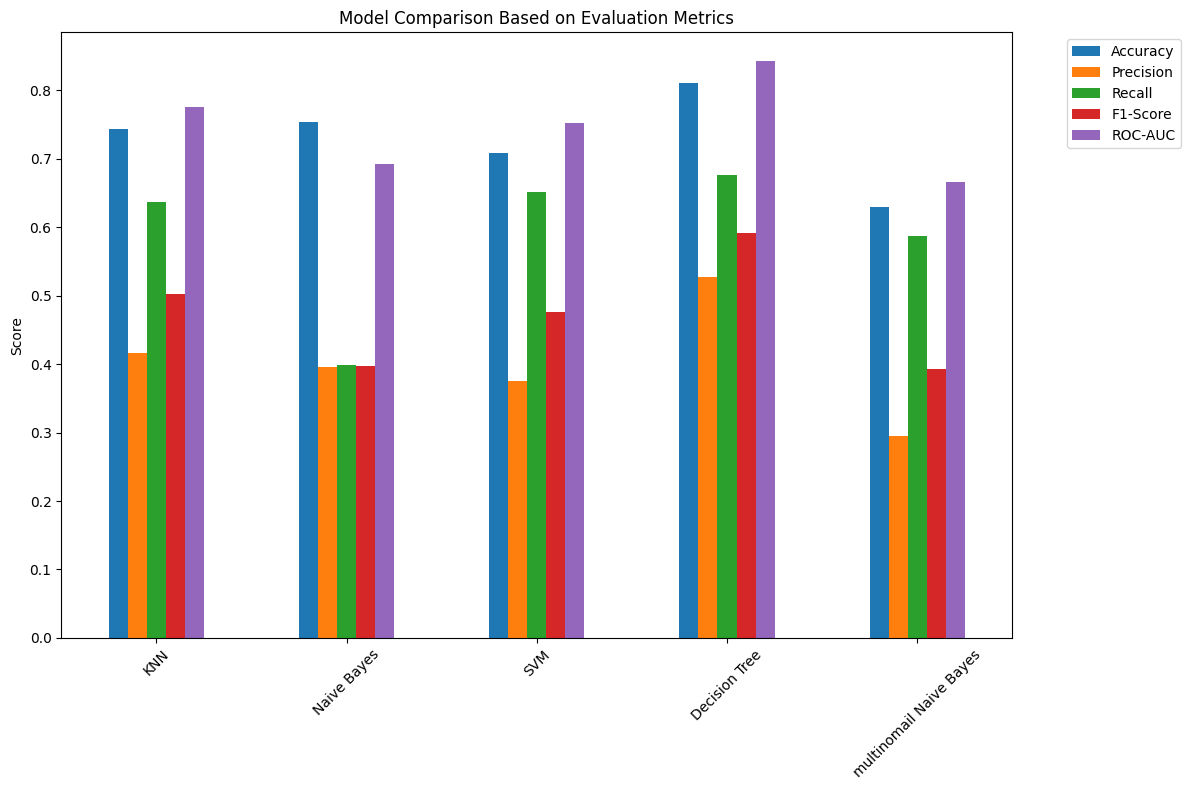

In [ ]:
# Plotting the metrics
results.plot(kind='bar', figsize=(12, 8))
plt.title('Model Comparison Based on Evaluation Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


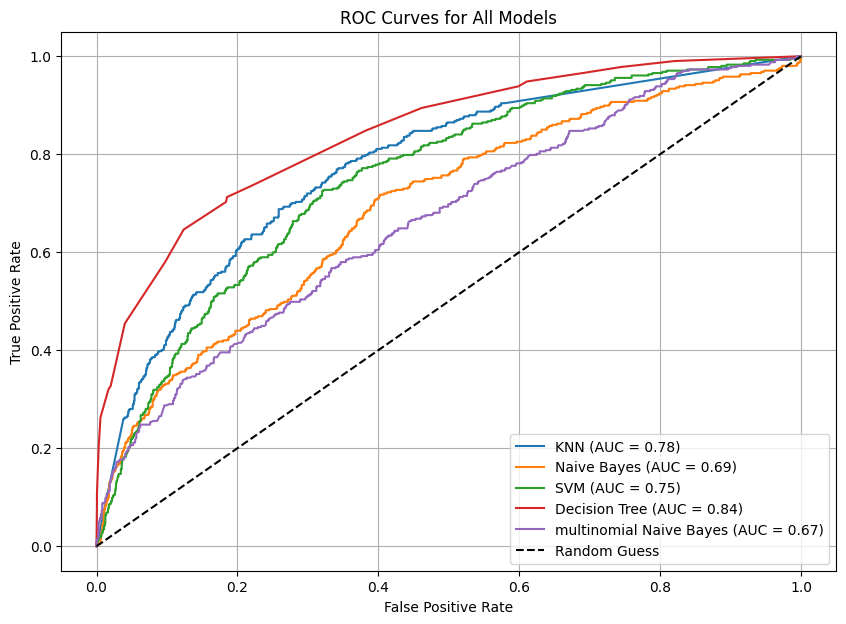

In [ ]:
# Calculate ROC curves
fpr_knn, tpr_knn, _ = roc_curve(y_knn_test, y_prob_knn[:, 1])
fpr_nb, tpr_nb, _ = roc_curve(y_nb_test_2, y_prob_nb[:, 1])
fpr_svm, tpr_svm, _ = roc_curve(y_svm_test, y_prob_svm[:, 1])
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt[:, 1])
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, y_prob_mnb[:, 1])

# Plotting ROC Curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {knn_metrics["ROC-AUC"]:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {nb_metrics["ROC-AUC"]:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {svm_metrics["ROC-AUC"]:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_metrics["ROC-AUC"]:.2f})')
plt.plot(fpr_mnb, tpr_mnb, label=f'multinomial Naive Bayes (AUC = {mnb_metrics["ROC-AUC"]:.2f})')
# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **Model deployment**

In [ ]:
# Save the models using joblib.dump
joblib.dump(best_knn, 'best_knn.pkl')
joblib.dump(gnb, 'gnb.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(best_dtree, 'best_dtree.pkl')

# Save the scalers
joblib.dump(standard_scaler, 'standard_scaler.pkl')
joblib.dump(robust_scaler, 'robust_scaler.pkl')

['robust_scaler.pkl']

In [ ]:
def load_models():
    models = {
        'KNN': joblib.load('best_knn.pkl'),
        'Naive Bayes': joblib.load('gnb.pkl'),
        'SVM': joblib.load('svm_model.pkl'),
        'Decision Tree': joblib.load('best_dtree.pkl')
    }
    scalers = {
        'standard': joblib.load('standard_scaler.pkl'),
        'robust': joblib.load('robust_scaler.pkl')
    }
    return models, scalers

def get_user_input():
    print("Enter customer data:")
    data = {}
    features = [
        'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
        'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Age_Tenure_Interaction', 'Active_Balance', 'Active_NumProducts',
        'Balance_Salary_Ratio', 'Balance_Credit_Ratio', 'Stability_Score',
        'Credit_Utilization', 'Product_Engagement', 'Age_Balance_Ratio'
    ]

    for feature in features:
        data[feature] = float(input(f"{feature}: "))

    return np.array(list(data.values())).reshape(1, -1)

def select_model():
    print("Select a model for prediction:")
    print("1: K-Nearest Neighbors (KNN)")
    print("2: Naive Bayes")
    print("3: Support Vector Machine (SVM)")
    print("4: Decision Tree")
    choice = input("Enter the number corresponding to your choice: ")

    model_map = {
        '1': 'KNN',
        '2': 'Naive Bayes',
        '3': 'SVM',
        '4': 'Decision Tree'
    }

    return model_map.get(choice, 'KNN')

def preprocess_input(model_name, scalers, input_data):
    if model_name in ['KNN', 'SVM']:
        return scalers['robust'].transform(input_data)
    elif model_name == 'Naive Bayes':
        return scalers['standard'].transform(input_data)
    else:
        return input_data

def main():
    models, scalers = load_models()
    user_data = get_user_input()
    selected_model_name = select_model()

    preprocessed_data = preprocess_input(selected_model_name, scalers, user_data)

    model = models[selected_model_name]
    prediction = model.predict(preprocessed_data)

    print(f"Prediction using {selected_model_name}: {'Exited' if prediction[0] == 1 else 'Not Exited'}")

if __name__ == "__main__":
    main()



Enter customer data:
CreditScore: 585
Age: 36
Tenure: 7
Balance: 0
NumOfProducts: 2
HasCrCard: 1
IsActiveMember: 0
EstimatedSalary: 94283.09
Age_Tenure_Interaction: 252
Active_Balance: 0
Active_NumProducts: 0
Balance_Salary_Ratio: 0
Balance_Credit_Ratio: 0
Stability_Score: 0
Credit_Utilization: 585
Product_Engagement: 0
Age_Balance_Ratio: 36
Select a model for prediction:
1: K-Nearest Neighbors (KNN)
2: Naive Bayes
3: Support Vector Machine (SVM)
4: Decision Tree
Enter the number corresponding to your choice: 1
Prediction using KNN: Not Exited


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [1]:
!git --version

git version 2.34.1


In [2]:
!git clone https://github.com/youseflasheen/Customer-Churn-Detection.git

Cloning into 'Customer-Churn-Detection'...


In [3]:
%cd Customer-Churn-Detection

/content/Customer-Churn-Detection


In [4]:
!cp /content/Customer-Churn-Detection.ipynb /content/Customer-Churn-Detection/

cp: cannot stat '/content/Customer-Churn-Detection.ipynb': No such file or directory
